# Spatial and Identity Tandem VAE
Inspired by Olshausen and Cheung's work we try to segregate identity from spatial information in an unsupervised way

TODO:
- ~~Implement cross-covariance penalty~~
    - https://stackoverflow.com/questions/45874928/how-to-compute-covariance-in-tensorflow
    - https://arxiv.org/abs/1412.6583
    - https://en.wikipedia.org/wiki/Cross-covariance
    - ~~Needs to be per-batch basis, use regularization?~~ Just operate on the layer, it has shape [batch,dim]

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras as keras
from keras.layers import Dense,Input,Lambda,Concatenate,Activation, Conv2D
from keras.models import Model,load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback
from keras.losses import categorical_crossentropy,logcosh
import keras.backend as K
from keras.datasets import mnist
from keras.metrics import categorical_accuracy
from keras.callbacks import BaseLogger,RemoteMonitor,TerminateOnNaN

from tqdm import tqdm as tqdm

from src.models import build_dense
from src.utils import ElasticSearchMonitor

Using TensorFlow backend.


## Load train and test MNIST data from Keras

In [2]:
# (x_train, y_train,w_train), (x_test,y_test,w_test) = emnist.load_byclass()
(x_train, y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
class_ids = np.unique(y_train)
masks_train = [y_train==i for i in class_ids]
masks_test = [y_test==i for i in class_ids]

y_test_oh = to_categorical(y_test,num_classes=10)
y_train_oh = to_categorical(y_train,num_classes=10)

digit_mask = lambda y: y<10 
uppercase = lambda y: (y>=10) & (y<36)
lowercase = lambda y: (y>=36) & (y<62)

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)
# plt.imshow(x_train[masks[4]][10].reshape(28,28).T)

(60000, 784)
(10000, 784)


In [3]:
# Make dataset thats just a copy with random offsets
num_train = len(y_train)
num_test = len(y_test)

# pre-allocate shifted inputs
sx_train = np.empty((num_train,784*4))
sx_test = np.empty((num_test,784*4))

# pre-allocate list of dx,dy shifts for each image
delta_train = np.empty((num_train,2))
delta_test = np.empty((num_test,2))

def random_offset(X,scale=2):
    bg_size=(28*scale,28*scale)
    
    dx = int(np.random.randint(-10,10))+14
    dy = int(np.random.randint(-10,10))+14
    
    dx = max(dx,0)
    dx = min(dx,bg_size[0]-28)
    
    dy = max(dy,0)
    dy = min(dy,bg_size[0]-28)
#     print(dx,dy)
    new_im = np.zeros(bg_size)
    new_im[dx:dx+28,dy:dy+28] = letter
    
    return new_im,np.array([dx,dy])

print('making training data...')
for i in tqdm(np.arange(num_train)):
    letter = x_train[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_train[i] = new_im.reshape(1,4*784)
    delta_train[i] = offsets

print('making testing data...')
for i in tqdm(np.arange(num_test)):
    letter = x_test[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_test[i] = new_im.reshape(1,4*784)
    delta_test[i] = offsets

  6%|▋         | 3797/60000 [00:00<00:01, 37954.74it/s]

making training data...


 36%|███▌      | 3624/10000 [00:00<00:00, 36229.15it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 35971.79it/s]


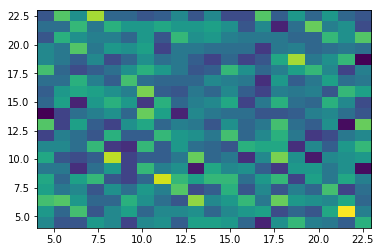

In [4]:
plt.hist2d(delta_test[:,0],delta_test[:,1],bins=20);

Example of a shifted digit on a larger background

3


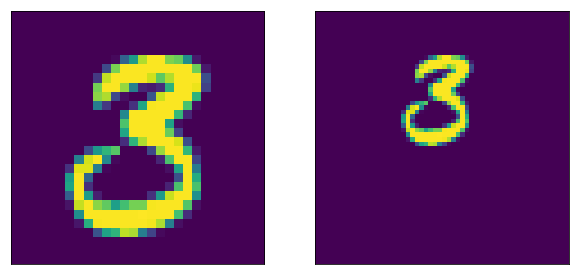

In [5]:
i = 250
print(y_train[masks_train[3]][i])
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(x_train[masks_train[3]][i].reshape(28,28))
axs[1].imshow(sx_train[masks_train[3]][i].reshape(28*2,28*2))

axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

fig.savefig('./shifted_mnist_3.png',dpi=300)

## Define Model
```
|     Inputs (3136)     |
 \      h1 (1500)      /
  |     h2 (1500)     |
  
     |z_hat| |y_hat|
     
    /   h3 (1500)   \
   |    h4 (1500)    |
```   

In [6]:
encoding_dims = [3000,1500]
z_dim = 2
y_dim = 5

# randomly shifted image
inputs = Input(shape=(784*4,))
# encoded = Dense(encoding_dim,activation='relu')(inputs)
encoded = build_dense(inputs,encoding_dims,activations='relu')

> dist_sample = sampler( args=(mean,std) )
>
>parameterizes a normal distribution from a mean and std and samples it

In [7]:
def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],K.shape(mean)[1]),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

In [8]:
z_mean = Dense(z_dim,name='z_mean')(encoded)
lat_vec = z_mean
# z_log_sigma = Dense(z_dim)(encoded)
# "layerize" z_hat random variable
# lat_vec = Lambda(sampler,name='z_sample')([z_mean,z_log_sigma])

y_hat = Dense(10,activation='softmax',name='y_hat')(encoded)
# y_hat = Dense(y_dim,name='y_mean')(encoded)
# y_hat_sigma = Dense(y_dim,name='y_sigma')(encoded)
# y_hat = Lambda(sampler, name='y_hat')([y_hat_mean,y_hat_sigma])
# y_hat = Dense(2,name='y_hat')(encoded)

# latent class repr
# y_hat = Dense(2,activation='sigmoid')(encoded)
# y_int = Dense(50,activation='relu')(y_hat)
# y_int = Dense(250,activation='relu')(y_int)
y_class = y_hat

# Concatenate with One-hot identity vector
combo_vec = Concatenate()([lat_vec,y_hat])

# Expand back out input dimensions (batch_size x im_size)

decoded_mean = build_dense(combo_vec,[encoding_dims[1],encoding_dims[0]]+[4*784],activations=['relu','relu','sigmoid'])
# decoded_mean = build_dense(combo_vec,[encoding_dims[1],encoding_dims[0]]+[4*784],activations=['relu','relu','sigmoid'])
tandem_vae = Model(inputs,decoded_mean)  

#### Combined Loss function

- Reconstruction loss (sum of squared error)

$ \sum\limits_{n} (X - \bar{X})^2 $
- Cross-covariance (XCov) of latent vars (z_hat, y_hat)
- Classification loss (categorical crossentropy)

In [9]:
from src.losses import *
        
def acc(y_true,y_pred):
    return categorical_accuracy(y_true,y_class)

def kl_loss_tot(y_true,y_pred):
    return kl_loss_z(y_true,y_pred)

def xentropy(y_true,y_pred):
    return 3*categorical_crossentropy(y_true,y_class)

def recon_mse(y_true,y_pred):
    return K.mean(K.sum(K.square(y_pred-inputs),axis=-1),axis=0)

In [10]:
recon_loss = ReconstructionLoss(inputs=inputs,outputs=decoded_mean)
xcov = XCov(y_hat,z_mean,weight=1)
# kl_loss_z = KLDivergenceLoss(z_log_sigma,z_mean,weight=0.001,name='DKL_z')
# kl_loss_y = KLDivergenceLoss(y_hat_sigma,y_hat_mean, weight=0.0001, name='DKL_y')

In [11]:
tandem_vae = Model(inputs,decoded_mean)
def vae_loss(y_true,y_pred):
    total_loss = 0
    loss_fns = [
        K.sum(recon_loss(y_true,y_pred)),
        10*xcov(y_true,y_pred),
        K.sum(10*categorical_crossentropy(y_true,y_class)),
#         K.sum(kl_loss_z(y_true,y_pred))/128,
#         K.sum(kl_loss_y(y_true,y_pred))
    ]
#     print(K.int_shape(xcov(y_true,y_pred)))
    for L in loss_fns:
        total_loss += L
        
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')

tandem_vae.compile(loss=vae_loss,optimizer='nadam',metrics=[recon_loss,recon_mse,xcov,acc,xentropy])


In [12]:
tandem_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1500)         4501500     dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            3002        dense_2[0][0]                    
__________________________________________________________________________________________________
y_hat (Den

## Train the model

In [13]:
# logger = RemoteMonitor(root='http://localhost:9200',path='/tensorflow/train_batch/')
examples=10
choices = np.random.choice(np.arange(len(y_test)),examples)
test_ims = sx_train[choices[:3]]
# print(test_ims.shape)

es_logger = ElasticSearchMonitor(root='http://localhost:9200',path='/tensorflow')
ToN = TerminateOnNaN()

In [14]:
y_train_oh.shape

(60000, 10)

In [15]:
tandem_vae.fit(x=sx_train,y=y_train_oh,validation_split=0.1,
               shuffle=True,
               epochs=50,
               batch_size=128,
               callbacks=[es_logger,ToN],
               verbose=0
              )

session ID:  v0XCeD
posted epoch results!
{'session': 'v0XCeD', 'recon': '0.020734655140726654', 'loss': '952.4202661494502', 'val_recon': '0.01702904339134693', 'val_xentropy': '1.0522211418151854', '@timestamp': '2018-08-31 13:15:12', 'val_loss': '449.8623502604167', 'recon_mse': '65.02388010547779', 'val_xcov': '0.006715804190685352', 'xcov': '0.0037697480585244126', 'val_recon_mse': '53.40308122762044', 'acc': '0.7554444444091232', 'xentropy': '2.226406504595721', 'val_acc': '0.8871666661898295'}
posted epoch results!
{'session': 'v0XCeD', 'recon': '0.0171272240286624', 'loss': '340.0359240541811', 'val_recon': '0.016505607277154923', 'val_xentropy': '0.8299235138893127', '@timestamp': '2018-08-31 13:15:23', 'val_loss': '355.341033203125', 'recon_mse': '53.71097588546188', 'val_xcov': '0.008291919648647308', 'xcov': '0.008289296400767785', 'val_recon_mse': '51.761585042317705', 'acc': '0.9157037036507218', 'xentropy': '0.7917618234599079', 'val_acc': '0.9138333328564961'}
posted ep

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112583). Check your callbacks.
  % delta_t_median)


posted epoch results!
{'session': 'v0XCeD', 'recon': '0.01718702645710221', 'loss': '83.67331095151548', 'val_recon': '0.017218284224470456', 'val_xentropy': '1.7284973055521646', '@timestamp': '2018-08-31 13:21:59', 'val_loss': '737.4496994628906', 'recon_mse': '53.898516173186124', 'val_xcov': '0.009516667144993942', 'xcov': '0.011805244006906395', 'val_recon_mse': '53.996540334065756', 'acc': '0.9884259259435866', 'xentropy': '0.19077244547107775', 'val_acc': '0.9284999995231629'}
posted epoch results!
{'session': 'v0XCeD', 'recon': '0.017219316068070905', 'loss': '50.27870056653906', 'val_recon': '0.01730278923610846', 'val_xentropy': '1.692930773417155', '@timestamp': '2018-08-31 13:22:10', 'val_loss': '721.9386408691406', 'recon_mse': '53.999776346842445', 'val_xcov': '0.009014308092494806', 'xcov': '0.011067868572694284', 'val_recon_mse': '54.261548116048175', 'acc': '0.9922962962962963', 'xentropy': '0.11241742935160572', 'val_acc': '0.932'}
posted epoch results!
{'session': 'v

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128013). Check your callbacks.
  % delta_t_median)


posted epoch results!
{'session': 'v0XCeD', 'recon': '0.01726394281619125', 'loss': '50.74940968704224', 'val_recon': '0.017272747750083604', 'val_xentropy': '1.8577062071412802', '@timestamp': '2018-08-31 13:24:14', 'val_loss': '793.5992333831787', 'recon_mse': '54.139725756609884', 'val_xcov': '0.011344197998444239', 'xcov': '0.013082434821459982', 'val_recon_mse': '54.16733806355794', 'acc': '0.9938703703703704', 'xentropy': '0.11345949493961571', 'val_acc': '0.9326666671435039'}
posted epoch results!
{'session': 'v0XCeD', 'recon': '0.017242875155475405', 'loss': '63.96502417613842', 'val_recon': '0.01721886693437894', 'val_xentropy': '1.960928530772527', '@timestamp': '2018-08-31 13:24:25', 'val_loss': '837.3514267578125', 'recon_mse': '54.073657803005645', 'val_xcov': '0.012488598167896272', 'xcov': '0.012777414321347519', 'val_recon_mse': '53.998367614746094', 'acc': '0.9927592592062774', 'xentropy': '0.14448816645732587', 'val_acc': '0.9316666661898295'}


In [16]:
tandem_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1500)         4501500     dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            3002        dense_2[0][0]                    
__________________________________________________________________________________________________
y_hat (Den

In [17]:
z_mean_encoder = Model(inputs,z_mean)
y_hat_encoder = Model(inputs,y_hat)
# y_int_encoder = Model(inputs,y_int)
classifier = Model(inputs,y_class)
decoder_inp = Input(shape=(10+z_dim,))
dec_layers = tandem_vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
_gen_x = dec_layers[2](_gen_x)
generator = Model(decoder_inp,_gen_x)

In [18]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
y_hat (Dense)                (None, 10)                15010     
Total params: 13,927,510
Trainable params: 13,927,510
Non-trainable params: 0
_________________________________________________________________


In [19]:
z_mean_enc = z_mean_encoder.predict(sx_test,batch_size=128)
y_class_enc = classifier.predict(sx_test,batch_size=128)
y_hat_enc = y_hat_encoder.predict(sx_test,batch_size=128)
# y_int_enc = y_int_encoder.predict(sx_test,batch_size=128)

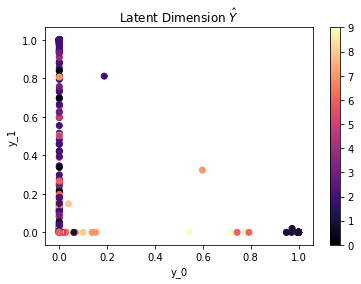

In [20]:
y_test
plt.scatter(y_hat_enc[:,1],y_hat_enc[:,2],c=y_test,cmap='magma')
plt.xlabel('y_0')
plt.ylabel('y_1')
plt.title(r"Latent Dimension $\hat{Y}$")
plt.colorbar()

In [21]:
# tandem_vae.save_weights('../models/tandem_vae/vae_weights.h5')
# generator.save_weights('../models/tandem_vae/generator_weights.h5')
# lat_encoder.save_weights('../models/tandem_vae/encoder.h5')

In [22]:
classifier.compile(loss='categorical_crossentropy',optimizer='adagrad',metrics=['accuracy'])
classifier_perf = classifier.evaluate(sx_test,to_categorical(y_test,num_classes=10))

print('Classification Accuracy: ',classifier_perf[1])

10000/10000 [==============================] - 1s 55us/step
Classification Accuracy:  0.9228


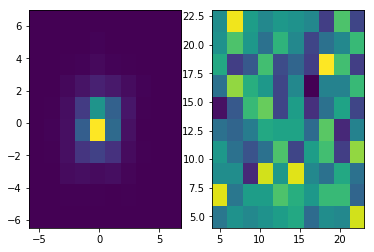

In [23]:
fig,axs = plt.subplots(1,2)

axs[0].hist2d(z_mean_enc[:,0],z_mean_enc[:,1]);
axs[1].hist2d(delta_test[:,0],delta_test[:,1]);
# plt.colorbar()

(5, 12)


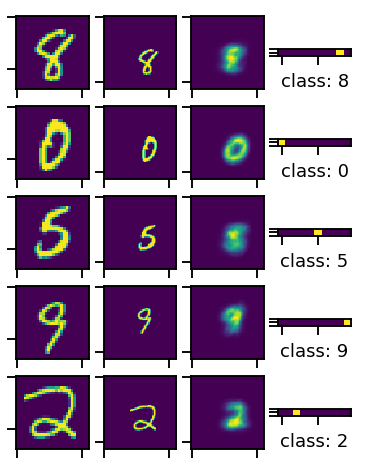

In [24]:
examples=5
sns.set_context('talk')
# sns.set_style('whitegrid')
y_test_oh = to_categorical(y_test,num_classes=10)

z0mean = z_mean_enc[:,0].mean()
z1mean = z_mean_enc[:,1].mean()
z0_sigma = z_mean_enc[:,0].std()
z1_sigma = z_mean_enc[:,1].std()
# z2_sigma = x_test_lat_enc[:,2].std()

fig,axs = plt.subplots(examples,4,figsize=(6,8))
choices = np.random.choice(np.arange(len(y_test)),examples)
# lat_vec_ = z_mean_enc[choices]
lat_vec_ = np.concatenate([z_mean_enc[choices],y_hat_enc[choices]],axis=1)
print(lat_vec_.shape)
dec_test = generator.predict(lat_vec_)

# print(x_test_encoded[choices])

for i,idx in enumerate(choices):
    rec_true_im = x_test[idx].reshape(28,28)
    in_im = sx_test[idx].reshape(28*2,28*2)
    dec_im = dec_test[i].reshape(28*2,28*2)
    
    axs[i,0].imshow(rec_true_im)
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticklabels([])
    
    axs[i,1].imshow(in_im)
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticklabels([])
    
    axs[i,2].imshow(dec_im)
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticklabels([])
#     axs[2,i].set_xlabel("class: {}".format(str(np.argmax(y_class_enc[idx]))))
    
    axs[i,3].imshow(y_class_enc[idx].reshape(-1,1).T)
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticklabels([])
    axs[i,3].set_xlabel("class: {}".format(str(np.argmax(y_class_enc[idx]))))
    
# plt.tight_layout()
# sns.despine(fig=fig)
# plt.imshow(dec_test[2].reshape(28,28).T)

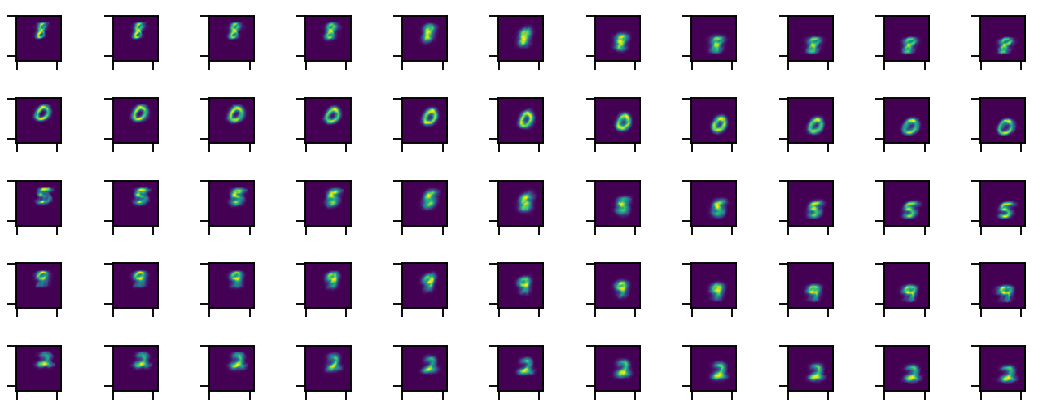

In [25]:
idx=2
bins = 11

all_sweeps = np.empty((examples,bins,4*784))


z0s = np.linspace(z0mean+(-2*z0_sigma),z0mean+(2*z0_sigma),num=bins)
z1s = np.linspace(z1mean+(-2*z1_sigma),z1mean+(2*z0_sigma),num=bins)
# z2s = np.linspace(-2*z2_sigma,2*z2_sigma,num=10)

fig,axs = plt.subplots(examples,bins,figsize=(15,int(15*(examples/bins))))

for j,vec in enumerate(lat_vec_):
    lat_size = vec.shape[-1]
    sweep = np.empty((bins,lat_size))
    
    for i,z in enumerate(z0s):
        sweep[i] = vec
        sweep[i,0] = z
    
    im_sweep = generator.predict(sweep)
    all_sweeps[j]=im_sweep
    
for i in np.arange(examples):
    for j in np.arange(bins):
        axs[i,j].imshow(all_sweeps[i,j].reshape(56,56))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        
plt.tight_layout()

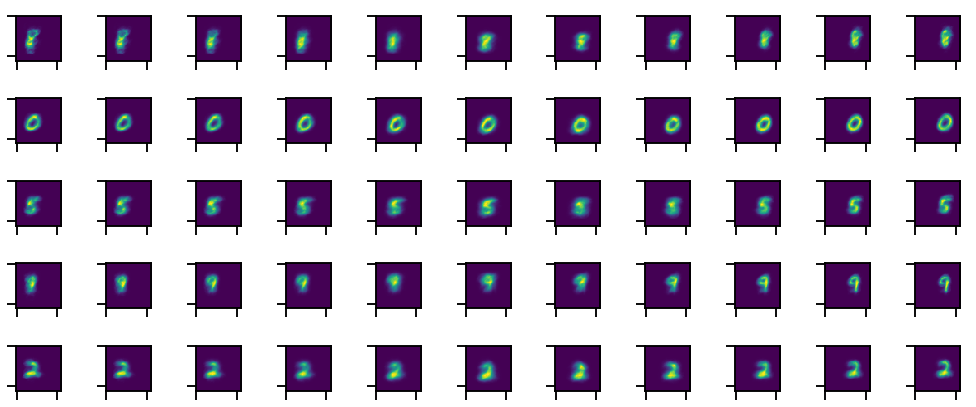

In [26]:
fig,axs = plt.subplots(examples,bins,figsize=(14,int(14*(examples/bins))))

for j,vec in enumerate(lat_vec_):
    lat_size = vec.shape[-1]
    sweep = np.empty((bins,lat_size))
    for i,z in enumerate(z1s):
        sweep[i] = vec
        sweep[i,1] = z
    
    im_sweep = generator.predict(sweep)
    all_sweeps[j]=im_sweep
    
for i in np.arange(examples):
    for j in np.arange(bins):
        axs[i,j].imshow(all_sweeps[i,j].reshape(56,56))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
plt.tight_layout()

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


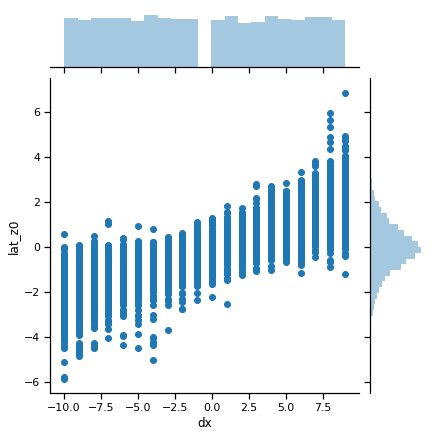

In [27]:
sns.set_context('notebook')
dxs = delta_test[:,0]
dys = delta_test[:,1]

g = sns.jointplot(dxs-14,z_mean_enc[:,0])
g.set_axis_labels(xlabel='dx',ylabel='lat_z0')


/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


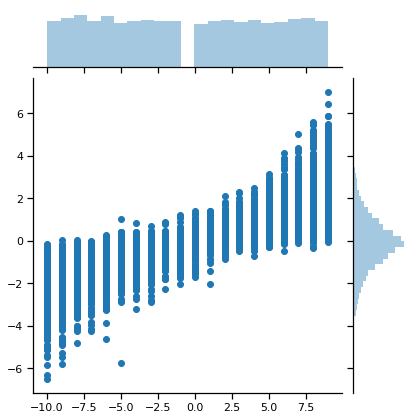

In [28]:
sns.jointplot(dys-14,z_mean_enc[:,1])

Text(0,0.5,'$\\hat{Z_1}$')

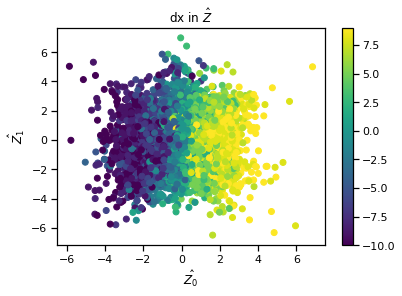

In [29]:
plt.scatter(z_mean_enc[:,0],z_mean_enc[:,1],c=dxs-14)
plt.colorbar()
plt.title(r"dx in $\hat{Z}$")
plt.xlabel(r"$\hat{Z_0}$")
plt.ylabel(r"$\hat{Z_1}$")

Text(0,0.5,'$\\hat{Z_1}$')

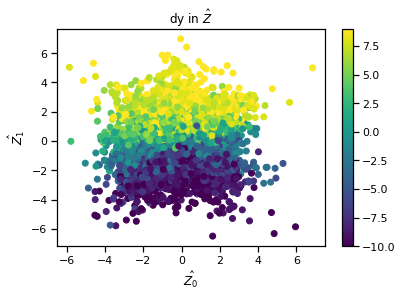

In [30]:
plt.scatter(z_mean_enc[:,0],z_mean_enc[:,1],c=dys-14)
plt.colorbar()
plt.title(r"dy in $\hat{Z}$")
plt.xlabel(r"$\hat{Z_0}$")
plt.ylabel(r"$\hat{Z_1}$")

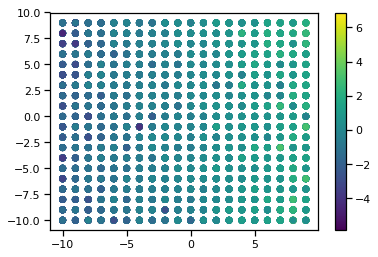

In [31]:
# fig,axs = plt.subplots(1,2,figsize=(12,5))
plt.scatter(dxs-14,dys-14,c=z_mean_enc[:,0])
# con = plt.contourf(dxs-14,dys-14,z_mean_enc[:,0])
# ax[1].scatter(dxs-14,dys-14,c=z_mean_enc[:,1])
# ax[0].set_xlabel('dx')
# ax[1].set_ylabel('dy')
plt.colorbar()
# plt.title('Latent Variable by x-shift (dx)')



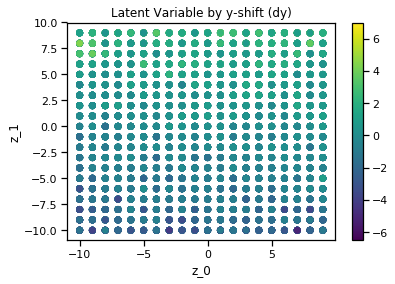

In [32]:
# fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(dxs-14,dys-14,c=z_mean_enc[:,1],)
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.title('Latent Variable by y-shift (dy)')

plt.colorbar()

In [33]:
# from sklearn.manifold import Isomap

# iso = Isomap(n_neighbors=20,n_components=1)
# lat_enc_iso = iso.fit_transform(X=x_test_lat_enc)

In [34]:
# lat_enc_iso.shape

In [35]:
plt.scatter(np.squeeze(lat_enc_iso),dxs-14,c=y_test)

NameError: name 'lat_enc_iso' is not defined

In [ ]:
plt.scatter(np.squeeze(lat_enc_iso),dys-14,c=y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(x_test_loc_enc[:, 0], x_test_loc_enc[:, 1],
            c=y_test,alpha=0.5
           )
plt.colorbar()
plt.scatter(x=x_test_loc_enc[choices][:,0],y=x_test_loc_enc[choices][:,1],marker='+',
            s=20**2,color='k')
plt.show()

In [ ]:
import bqplot.pyplot as bqplt
from bqplot import Tooltip
import pandas as pd

recs = []
for i,cid in enumerate(y_test):
    recs.append(dict(
        loc_z=x_test_loc_enc[i],
        loc_z0=x_test_loc_enc[i][0],
        loc_z1=x_test_loc_enc[i][1],
        id_z=x_test_encoded[i],
        id_z0=x_test_encoded[i][0],
        id_z1=x_test_encoded[i][1],
        class_id=cid,
        dx=delta_test[i][0],
        dy=delta_test[i][1]
    ))
enc_df = pd.DataFrame.from_records(recs)
enc_df.head()  


In [ ]:
enc_df.to_pickle('./tandem_encoder_df.pk')
np.save('./sx_test.npy',sx_test)
np.save('./dec_test.npy',dec_test)

In [ ]:
# bqplt.figure(title='Autoencoder Latent Space')
# def_tt = Tooltip(fields=['x', 'y'], formats=['', '.2f'])
# bqplt.scatter(enc_df.loc_z0.values,enc_df.loc_z1.values)
# # plt.colorbar()
# bqplt.show()